## Autoencoder Introduction and Compression
   #### Computer Vision Winter Semester 2021/2022 by Clemens Spielvogel
   
Autoencoders are a type of neural network used for efficient encoding of information in an abstract representation. This procedure is somewhat similar to classical dimensionality. Autoencoders can be fully connected or fully convolutional. In computer vision, they can be used for tasks such as image compression, image denoising, feature extraction, semantic segmentation and the filling of missing information in an image (neural painting).

### Dense Autoencoders

I the following you will see an example of a fully connected (=dense) autoencoder used for image compression. In this process, an image is fed through the autoencoder network to reconstruct the input image. During this process the autoencoder is forced to find an optimal representation of the original image input which fits into a number of values equal to the number of nodes in the bottleneck layer. 

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential, Model, layers
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
# Seeding random number generators to obtain reproducible results
seed_value = 0
os.environ["PYTHONHASHSEED"]=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Default matplotlib font color (change this to black if you are not using dark mode)
mpl.rcParams["text.color"] = "white"

In [3]:
def plot(test, encoded_representation, pred):
    """Plot three corresponding original, encoded and reconstructed images"""
    fig, ax = plt.subplots(3, 3)
    
    # Plotting parameters set to not show ticks and tick labels
    params = {"bottom": False,
              "left": False,
              "labelbottom": False,
              "labelleft": False}

    ax[0, 0].title.set_text("Original")
    ax[0, 1].title.set_text("Encoding")
    ax[0, 2].title.set_text("Predicted")

    ax[0, 0].imshow(test[0])
    ax[0, 0].tick_params(**params)
    ax[0, 1].imshow(encoded_representation[0])
    ax[0, 1].tick_params(**params)
    ax[0, 2].imshow(pred[0])
    ax[0, 2].tick_params(**params)

    ax[1, 0].imshow(test[1])
    ax[1, 0].tick_params(**params)
    ax[1, 1].imshow(encoded_representation[1])
    ax[1, 1].tick_params(**params)
    ax[1, 2].imshow(pred[1])
    ax[1, 2].tick_params(**params)

    ax[2, 0].imshow(test[2])
    ax[2, 0].tick_params(**params)
    ax[2, 1].imshow(encoded_representation[2])
    ax[2, 1].tick_params(**params)
    ax[2, 2].imshow(pred[2])
    ax[2, 2].tick_params(**params)

    plt.tight_layout()
    plt.show()

In the following you will see a very simple dense autoencoder which has an input layer, an output layer and one hidden layer, which is the bottleneck layer. As the process can be regarded as a pixelwise regression, we use mean squared error as loss metric. In addition to the autoencoder model, the function also returns the encoder model. This encoder model will later be used for displaying the compressed representation of the original image which the autoencoder came up with.

In [4]:
def create_autoencoder_model(input_shape, num_bottleneck_nodes):
    """Create autoencoder model. Returns autoencoder model and encoder model as tuple"""

    input_img = layers.Input(shape=input_shape)

    encoder = layers.Dense(num_bottleneck_nodes, activation="relu")(input_img)
    encoder_model = Model(input_img, encoder)

    decoder = layers.Dense(input_shape[0], activation="sigmoid")(encoder)
    autoencoder_model = Model(input_img, decoder)

    autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")

    return autoencoder_model, encoder_model

In the following function the workflow for the autoencoder analysis is conducted. Hyperparameters can be supplied as function arguments, in this case the number of nodes in the bottleneck layer and the number of epochs. Subsequently, the data is loaded, normalized and flattened out to be fit into the input nodes of the neural network. The model is trained and predictions are made. As we do not use the validation performance for fruther tuning, the validation performance can be regarded as test performance.  
Lastlt, a plot is generated to display the results of the analysis and give a picture of how the autoencoder compressed the image information.

In [5]:
def autoencoder_workflow(num_bottleneck_nodes, num_epochs):
    """Auoencoder based reconstruction workflow for MNIST data"""

    # Load data
    (train, _), (test, _) = mnist.load_data()   # Get training and test MNIST images

    # Get original shape
    original_dims = train[0].shape

    # Normalize and reshape
    train = (train.astype(np.float32) / 255).reshape((len(train), np.prod(train.shape[1:])))
    test = (test.astype(np.float32) / 255).reshape((len(test), np.prod(test.shape[1:])))

    # Get sample dimensions
    dims = train[0].shape

    # Create model
    model, encoder = create_autoencoder_model(dims, num_bottleneck_nodes)

    # Stopping criterion via early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)

    # Train model
    model.fit(train,
              train,
              epochs=num_epochs,
              validation_data=(test, test),
              verbose=True,
              callbacks=[callback])

    # Predict encoded representation
    encoded_representation = encoder.predict(test)

    # Predict reconstructed image
    pred = model.predict(test)

    # Determine suiting plotting shape for encoded representation
    if num_bottleneck_nodes % math.sqrt(num_bottleneck_nodes) == 0:
        reshape_dim1, reshape_dim2 = np.int16(math.sqrt(num_bottleneck_nodes)), np.int16(math.sqrt(num_bottleneck_nodes))
    elif num_bottleneck_nodes % 2 == 0:
        reshape_dim1, reshape_dim2 = np.int16(num_bottleneck_nodes / 2), 2
    else:
        reshape_dim1, reshape_dim2 = 1, num_bottleneck_nodes

    # Display results
    plot(test.reshape(len(test), original_dims[0], original_dims[1]),
         encoded_representation.reshape(len(test), reshape_dim1, reshape_dim2),
         pred.reshape(len(test), original_dims[0], original_dims[1]))

Next, we will run the autoencoder workflow with different numbers of nodes in the bottleneck layer. Notice the decrease in quality of the reconstructed images. The encoding you find between the original and predicted image represents the way the image was represented at the bottleneck layer.
Feel free to increase the number of epochs if the code runs sufficiently fast on your computer as the performance might further increase.

In [6]:
# Set epochs
num_epochs = 25

Epoch 1/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0086 - val_loss: 0.0022
Epoch 2/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 3/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0010 - val_loss: 9.9180e-04
Epoch 6/25
1875/1875 [==============================] - 3s 2ms/step - loss: 9.4121e-04 - val_loss: 9.5015e-04
Epoch 7/25
1875/1875 [==============================] - 3s 2ms/step - loss: 9.0611e-04 - val_loss: 9.2990e-04
Epoch 8/25
1875/1875 [==============================] - 3s 2ms/step - loss: 8.7787e-04 - val_loss: 9.3894e-04
Epoch 9/25
1875/1875 [==============================] - 3s 2ms/step - loss: 8.5044e-04 - val_loss: 8.9115e-04
Epoch 10/25
1875/1875 [=======================

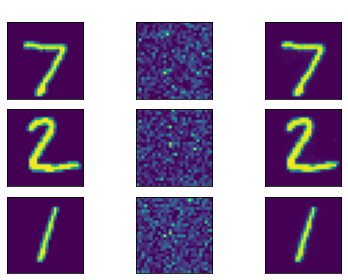

In [7]:
# Autoencoder with same number of bottleneck nodes as input image: 784
autoencoder_workflow(784, num_epochs)

Epoch 1/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0320 - val_loss: 0.0161
Epoch 2/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0133 - val_loss: 0.0113
Epoch 3/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 4/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 5/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 6/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0104 - val_loss: 0.0101
Epoch 7/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 8/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 9/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 10/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.010

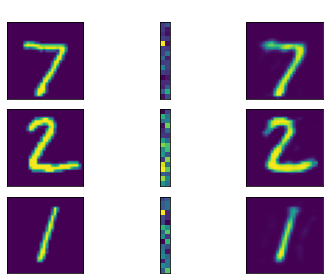

In [8]:
# Autoencoder with 32 bottleneck nodes
autoencoder_workflow(32, num_epochs)

Epoch 1/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0411 - val_loss: 0.0262
Epoch 2/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0249 - val_loss: 0.0233
Epoch 3/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0229 - val_loss: 0.0221
Epoch 4/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0222 - val_loss: 0.0216
Epoch 5/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0220 - val_loss: 0.0214
Epoch 6/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0218 - val_loss: 0.0213
Epoch 7/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0217 - val_loss: 0.0212
Epoch 8/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0216 - val_loss: 0.0211
Epoch 9/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0216 - val_loss: 0.0210
Epoch 10/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.021

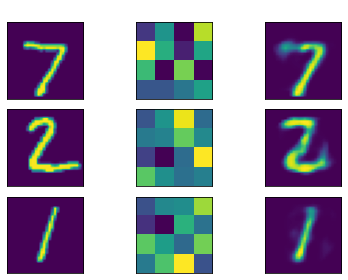

In [9]:
# Autoencoder with 16 bottleneck nodes
autoencoder_workflow(16, num_epochs)

Epoch 1/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0516 - val_loss: 0.0383
Epoch 2/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0373 - val_loss: 0.0358
Epoch 3/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0357 - val_loss: 0.0347
Epoch 4/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0349 - val_loss: 0.0342
Epoch 5/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0345 - val_loss: 0.0338
Epoch 6/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0343 - val_loss: 0.0337
Epoch 7/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0341 - val_loss: 0.0336
Epoch 8/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0340 - val_loss: 0.0335
Epoch 9/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0340 - val_loss: 0.0334
Epoch 10/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.033

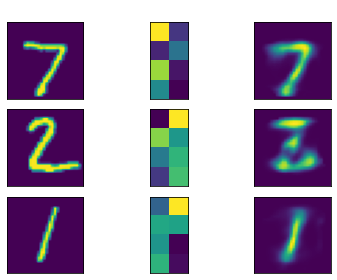

In [10]:
# Autoencoder with 8 bottleneck nodes
autoencoder_workflow(8, num_epochs)

Epoch 1/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0620 - val_loss: 0.0501
Epoch 2/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0492 - val_loss: 0.0480
Epoch 3/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0478 - val_loss: 0.0471
Epoch 4/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0472 - val_loss: 0.0467
Epoch 5/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0469 - val_loss: 0.0464
Epoch 6/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0467 - val_loss: 0.0462
Epoch 7/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0466 - val_loss: 0.0462
Epoch 8/25
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0465 - val_loss: 0.0461
Epoch 9/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0465 - val_loss: 0.0460
Epoch 10/25
1875/1875 [==============================] - 3s 2ms/step - loss: 0.046

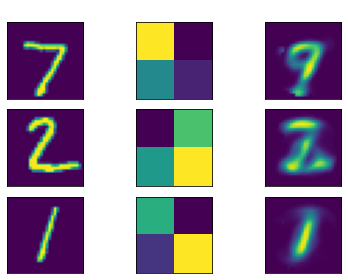

In [11]:
# Autoencoder with 4 bottleneck nodes
autoencoder_workflow(4, num_epochs)

### Convolutional Autoencoders

In contrast to dense autoencoders which only use fully connected layers, it is also possible to use convolutional layers for compression and decompression of images. Here, alternating convolutional layers and max pooling are used for encoding and alternating convolutional and upsampling layers are used for decoding. Convolutional autoencoders tend to have longer training times but may deliver better results in many cases.

In [12]:
def create_conv_autoencoder(input_shape):
    """Convolutional autoencoder architecture"""
    input_img = layers.Input(input_shape)

    encoded = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(input_img)
    encoded = layers.MaxPooling2D((2, 2))(encoded)
    encoded = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(encoded)
    encoded = layers.MaxPooling2D((2, 2))(encoded)
    encoded = layers.Conv2D(4, (3, 3), activation="relu", padding="same")(encoded)
    encoded = layers.MaxPooling2D((2, 2), padding="same")(encoded)

    encoder_model = Model(input_img, encoded)  # dims: 4 feature maps with size 4 x 4 (64 bottleneck nodes)

    decoded = layers.Conv2D(4, (3, 3), activation="relu", padding="same")(encoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(decoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2D(16, (3, 3), activation="relu")(decoded)
    decoded = layers.UpSampling2D((2, 2))(decoded)
    decoded = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(decoded)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.1), loss="mse")

    return autoencoder, encoder_model

In [13]:
# Get training and test MNIST images
(train, _), (test, _) = mnist.load_data()

# Add color dimensions
train = (train.astype(np.float32) / 255).reshape((len(train), 28, 28, 1))
test = (test.astype(np.float32) / 255).reshape((len(test), 28, 28, 1))

# Get dimensions from example image
dims = train[0].shape

In [14]:
# Create autoencoder and associated encoder model
autoencoder, encoder = create_conv_autoencoder(dims)

# Configure stopping criterion via early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)

# Train autoencoder
autoencoder.fit(train, train,
                validation_data=(test, test),
                batch_size=256,
                epochs=100,
                callbacks=[callback],)

Epoch 1/100
235/235 [==============================] - 2s 8ms/step - loss: 0.1485 - val_loss: 0.1017
Epoch 2/100
235/235 [==============================] - 2s 6ms/step - loss: 0.0808 - val_loss: 0.0678
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0618 - val_loss: 0.0581
Epoch 4/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0551 - val_loss: 0.0528
Epoch 5/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0509 - val_loss: 0.0493
Epoch 6/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0483 - val_loss: 0.0472
Epoch 7/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0466 - val_loss: 0.0456
Epoch 8/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0453 - val_loss: 0.0444
Epoch 9/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0442 - val_loss: 0.0433
Epoch 10/100
235/235 [==============================] - 2s 7ms/step - loss: 0.0432 - val_lo

The validation loss is good, although it might be improved further by increasing the number of epochs. Finally, we visualize some reconstructed images along with the corresponding original images.

In [15]:
# Predict reconstructed image
pred = autoencoder.predict(test)

In [16]:
def plot_with_filters(original, encoded, reconstructed, num_examples=1, num_filters=4):
    """Plot test set examples with original, filter activations and prediction"""

    assert num_filters <= encoded.shape[-1], \
    "num_filters={} exceeds number of available feature maps ({}).".format(num_filters, encoded.shape[-1])
    
    # Plotting parameters set to not show ticks and tick labels
    params = {"bottom": False,
              "left": False,
              "labelbottom": False,
              "labelleft": False}

    # Create a composite figure
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(num_filters * num_examples, num_examples)

    # Originals and reconstructions
    for example_index in range(num_examples):
        # Left column
        ax = fig.add_subplot(gs[example_index * num_filters:(example_index + 1) * num_filters, 0])
        ax.imshow(original[example_index])
        ax.tick_params(**params)

        # Left column title
        if example_index == 0:
            ax.title.set_text("Original")

        # Right columns
        ax = fig.add_subplot(gs[example_index * num_filters:(example_index + 1) * num_filters, 2])
        ax.imshow(reconstructed[example_index])
        ax.tick_params(**params)

        # Right column title
        if example_index == 0:
            ax.title.set_text("Reconstruction")

    # Encodings
    for filter_index in range(num_filters * num_examples):
        ax = fig.add_subplot(gs[filter_index, 1])
        ax.imshow(encoded[int(filter_index / num_filters), :, :, filter_index % num_filters])
        ax.tick_params(**params)

        # Mid column title
        if filter_index == 0:
            ax.title.set_text("Encoding")

    # Auto-format and show figure
    plt.tight_layout()
    plt.show()

Test dimensions: (10000, 28, 28)
Encoded dimensions: (10000, 4, 4, 4)
Reconstructed dimensions: (10000, 28, 28)


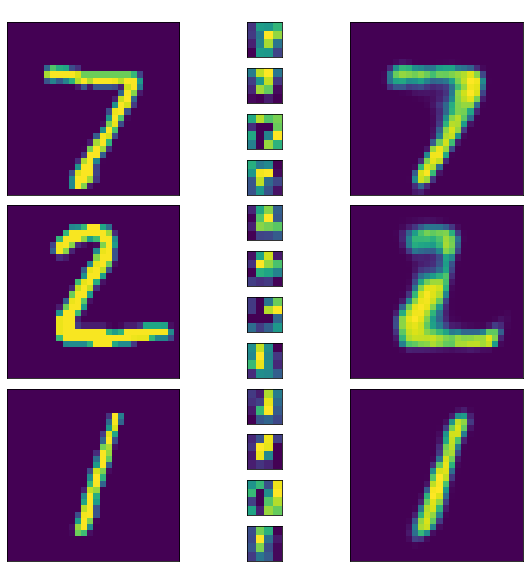

In [17]:
# Create encoded representation
encoded = encoder.predict(test)

# Reshaping image data for visualization
test_reshaped = test.reshape(len(test), dims[0], dims[1])
pred_reshaped = pred.reshape(len(pred), dims[0], dims[1])

# Display dimensions
print("Test dimensions:", test_reshaped.shape)
print("Encoded dimensions:", encoded.shape)
print("Reconstructed dimensions:", pred_reshaped.shape)

# Visualize three example images
plot_with_filters(test_reshaped, encoded, pred_reshaped, num_examples=3, num_filters=4)